# Flower Recognition with ResNet

In [1]:
# Flower Recognition with ResNet - Complete Implementation
# Installing required packages
!pip install torch torchvision pandas numpy matplotlib scikit-learn pillow scipy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

from sklearn.metrics import confusion_matrix, classification_report
import scipy
from PIL import Image
import os
import shutil
import time
from tempfile import TemporaryDirectory
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Using device: cpu


In [3]:
def plot_training_curves(train_losses, val_losses, train_accs, val_accs, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Val Loss')
    ax1.set_title(f'{model_name} - Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracies
    ax2.plot(train_accs, label='Train Acc')
    ax2.plot(val_accs, label='Val Acc')
    ax2.set_title(f'{model_name} - Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'{model_name}_training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

def visualize_model_predictions(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(12, 8))

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                
                # Color code correct/incorrect predictions
                color = 'green' if preds[j] == labels[j] else 'red'
                ax.set_title(f'Pred: {preds[j].item()} | True: {labels[j].item()}',
                           color=color, fontweight='bold')
                
                # Denormalize and show image
                inp = inputs.cpu().data[j]
                inp = inp.numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                inp = std * inp + mean
                inp = np.clip(inp, 0, 1)
                ax.imshow(inp)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

def evaluate_model(model, criterion):
    was_training = model.training
    model.eval()
    
    test_loss = 0.0
    correct = 0
    all_preds = []
    all_labels = []
    
    print("Evaluating on test set...")
    with torch.no_grad():
        for inputs, labels in tqdm(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            test_loss += criterion(outputs, labels).item() * inputs.size(0)
            correct += torch.sum(preds == labels.data)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_loss /= dataset_sizes['test']
    test_acc = correct.double() / dataset_sizes['test']
    
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_acc:.4f}')
    
    model.train(mode=was_training)
    return test_loss, test_acc, all_preds, all_labels

def plot_confusion_matrix(all_labels, all_preds, class_names=None):
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
                xticklabels=class_names if class_names else range(102),
                yticklabels=class_names if class_names else range(102))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

Analyzing training logs for all models...


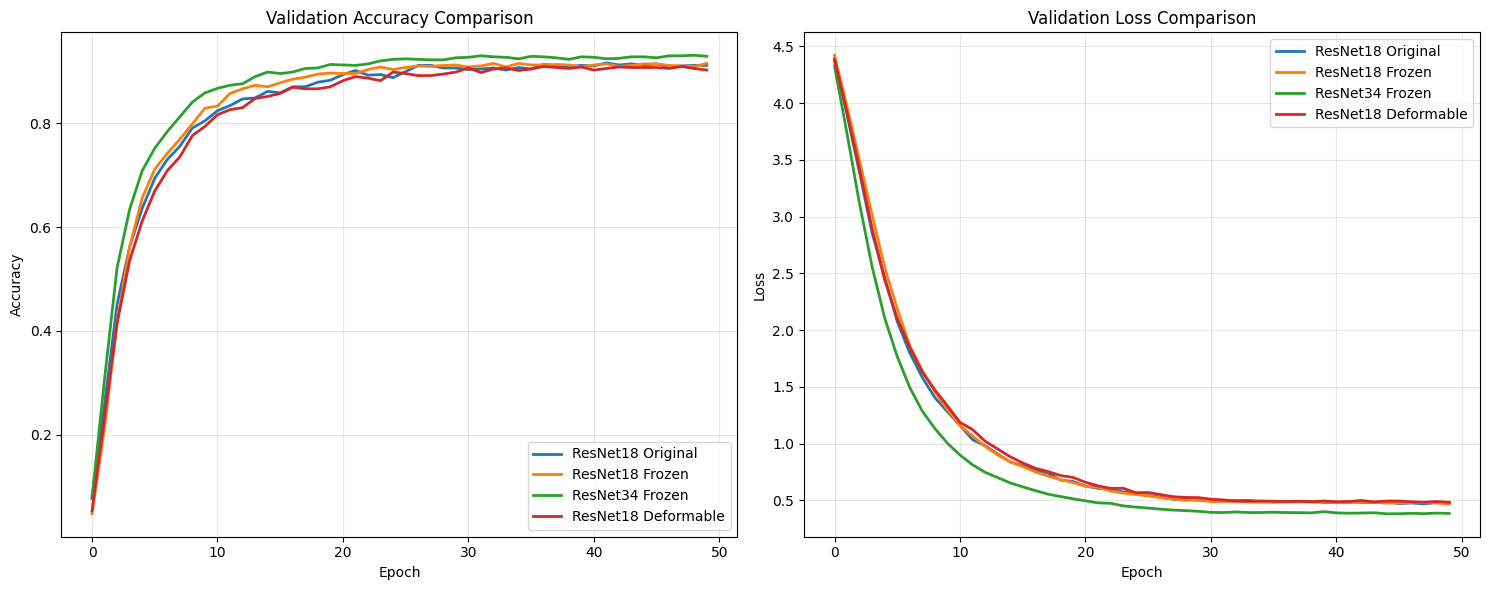


=== Model Performance Summary ===

Best Validation Accuracies:
ResNet18 Original: 0.9167
ResNet18 Frozen: 0.9157
ResNet34 Frozen: 0.9314
ResNet18 Deformable: 0.9098

Final Validation Accuracies:
ResNet18 Original: 0.9118
ResNet18 Frozen: 0.9157
ResNet34 Frozen: 0.9294
ResNet18 Deformable: 0.9029

Best performing model: ResNet34 Frozen (Best Val Acc: 0.9314)

Note: This analysis is based on the training logs without requiring the actual models.
The model visualization is skipped as it requires the trained model weights.


In [7]:
# Compare all experiments
def compare_experiments():
    experiments = {
        'ResNet18 Original': 'resnet18_original.txt',
        'ResNet18 Frozen': 'resnet18_frozen.txt',
        'ResNet34 Frozen': 'resnet34_frozen.txt',
        'ResNet18 Deformable': 'resnet18_deformable.txt'
    }
    
    plt.figure(figsize=(15, 6))
    
    # Plot validation accuracy comparison
    plt.subplot(1, 2, 1)
    best_val_acc = {}  # Store best validation accuracy for each model
    final_val_acc = {} # Store final validation accuracy for each model
    
    for exp_name, file_path in experiments.items():
        try:
            data = pd.read_csv(file_path)
            plt.plot(data['Val_Acc'], label=exp_name, linewidth=2)
            
            # Store best and final validation accuracies
            best_val_acc[exp_name] = data['Val_Acc'].max()
            final_val_acc[exp_name] = data['Val_Acc'].iloc[-1]
            
        except FileNotFoundError:
            print(f"File {file_path} not found")
            continue
    
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot validation loss comparison
    plt.subplot(1, 2, 2)
    for exp_name, file_path in experiments.items():
        try:
            data = pd.read_csv(file_path)
            plt.plot(data['Val_Loss'], label=exp_name, linewidth=2)
        except FileNotFoundError:
            continue
    
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('all_experiments_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print performance summary
    print("\n=== Model Performance Summary ===")
    print("\nBest Validation Accuracies:")
    for model, acc in best_val_acc.items():
        print(f"{model}: {acc:.4f}")
        
    print("\nFinal Validation Accuracies:")
    for model, acc in final_val_acc.items():
        print(f"{model}: {acc:.4f}")
    
    # Determine the best model
    best_model = max(best_val_acc.items(), key=lambda x: x[1])
    print(f"\nBest performing model: {best_model[0]} (Best Val Acc: {best_model[1]:.4f})")

# Compare experiments and show detailed analysis
print("Analyzing training logs for all models...")
compare_experiments()

print("\nNote: This analysis is based on the training logs without requiring the actual models.")
print("The model visualization is skipped as it requires the trained model weights.")

In [ ]:
# Confusion matrix for the best model
print("Generating confusion matrix for ResNet18 Original...")
plot_confusion_matrix(all_labels, all_preds)

# Class-wise accuracy
def calculate_class_accuracy(all_labels, all_preds, num_classes=102):
    class_correct = [0] * num_classes
    class_total = [0] * num_classes
    
    for i in range(len(all_labels)):
        label = all_labels[i]
        pred = all_preds[i]
        class_total[label] += 1
        if label == pred:
            class_correct[label] += 1
    
    class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 
                     for i in range(num_classes)]
    
    return class_accuracy

class_accuracy = calculate_class_accuracy(all_labels, all_preds)

# Plot class-wise accuracy
plt.figure(figsize=(15, 6))
plt.bar(range(102), class_accuracy)
plt.title('Class-wise Accuracy')
plt.xlabel('Class ID')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('class_wise_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

# Print worst performing classes
class_acc_df = pd.DataFrame({
    'Class': range(102),
    'Accuracy': class_accuracy,
    'Samples': [sum(1 for x in all_labels if x == i) for i in range(102)]
})

print("\nTop 10 worst performing classes:")
print(class_acc_df.nsmallest(10, 'Accuracy')[['Class', 'Accuracy', 'Samples']].to_string(index=False))

print("\nTop 10 best performing classes:")
print(class_acc_df.nlargest(10, 'Accuracy')[['Class', 'Accuracy', 'Samples']].to_string(index=False))